# Model implementation, training, testing and results visualization

# Data downloading

In [ ]:
# Download the data
%%capture
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip
!pip install -U sentence-transformers

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(21)

In [ ]:
# Load rated data. Take a split of the initial dataset
ua_base = pd.read_csv("ml-100k/ua.base",  sep="\t", header=None, names=["user_id", "item_id", "rating", "timestamp"])
ua_test = pd.read_csv("ml-100k/ua.test",  sep="\t", header=None, names=["user_id", "item_id", "rating", "timestamp"])

ua_base

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
90565,943,1047,2,875502146
90566,943,1074,4,888640250
90567,943,1188,3,888640250
90568,943,1228,3,888640275


In [ ]:
# Users and movies information
# Index is an id
users = pd.read_csv("ml-100k/u.user",  sep="|", header=None, names=["age", "gender", "occupation", "zip_code"], index_col=0)
genres = pd.read_csv("ml-100k/u.genre",sep="|", header=None, index_col=1)
movies_columns = ["movie_title", "release_date", "video_release_date", "IMDB_URL"] + genres.index.astype(str).tolist()
movies = pd.read_csv("ml-100k/u.item",sep="|", header=None, index_col=0, names=movies_columns,encoding='latin-1')

In [ ]:
from numpy import dot
from numpy.linalg import norm
import torch
import tqdm

In [ ]:
# join ua ub
train_dataset = pd.read_csv("train_dataset.csv", index_col=0)
val_dataset = pd.read_csv("val_dataset.csv", index_col=0)

X_train = torch.tensor(train_dataset.loc[:, train_dataset.columns != 'rating'].values, dtype=torch.float)
y_train = torch.tensor(train_dataset["rating"].to_numpy())

X_val = torch.tensor(val_dataset.loc[:, val_dataset.columns != 'rating'].values, dtype=torch.float)
y_val = torch.tensor(val_dataset["rating"].to_numpy())

# Main model

Based on feed-forward neural network

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(in_features = 426, out_features = 150),
    torch.nn.LeakyReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(in_features = 150, out_features = 20),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(in_features = 20, out_features = 1),
    torch.nn.Sigmoid()
)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)

X_val = X_val.to(device)
y_val = y_val.to(device)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=len(y_train), shuffle=True).to(device)

In [ ]:
def threshold(inp, max_k):
    # Convert continuous ratings to a discrete numbers
    # inp - input vector of numbers
    # max_k - maximal output rating
    res = torch.zeros(inp.shape).to(device)
    for i in range(1, max_k):
        res += ((inp > i / max_k) & (inp <= (i+1) / max_k)).int() * i
    return res

all(threshold(y_train / 4, 5) == y_train)

True

In [ ]:
def train(model, X_train, y_train, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train).reshape(-1)
    loss = criterion(y_pred, y_train/4)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    cur_loss = loss.item()
    return cur_loss

def eval(model, X_val, y_val, criterion, optimizer):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val).reshape(-1)
        loss = criterion(y_pred, y_val / 4)
        cur_loss = loss.item()
        pred = threshold(y_pred, 2)
        acc = torch.sum(pred == threshold(y_val / 4, 2))

    return acc / len(y_val), cur_loss

In [ ]:
# Train the model
criterion = torch.nn.HuberLoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

num_epochs = 350
val_tick = 25
train_losses = []
val_losses = []
val_acc = []
prev_acc = 0
counter = 0
pbar = tqdm.tqdm(range(num_epochs))

for epoch in pbar:
    # Forward pass
    for X, y in train_loader:
        cur_loss = train(model, X, y, criterion, optimizer)
        pbar.set_description(f"Loss: {cur_loss :.5f}")

    # Print the val loss every 100 epochs
    if ((epoch+1) % val_tick == 0) or (epoch == 0) :
        train_losses.append(cur_loss)

        acc, cur_loss = eval(model, X_val, y_val, criterion, optimizer)
        val_losses.append(cur_loss)
        val_acc.append(acc.item())

        print(f'\nEpoch [{epoch+1}/{num_epochs}], Accuracy: {acc}, Loss: {cur_loss}' )

        # Learning rate scheduler
        if prev_acc >= acc:
            counter += 1
        if counter >= 3:
            lr = lr / 2
            print(f"Learning rate set to {lr}")
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            counter = 0
        prev_acc = acc
        print()


Loss: 0.04687:   0%|          | 1/350 [00:01<07:48,  1.34s/it]


Epoch [1/350], Accuracy: 0.5799575448036194, Loss: 0.04715486243367195



Loss: 0.03950:   7%|▋         | 25/350 [00:33<06:27,  1.19s/it]


Epoch [25/350], Accuracy: 0.5799575448036194, Loss: 0.03904370591044426



Loss: 0.03747:  14%|█▍        | 50/350 [01:04<06:46,  1.35s/it]


Epoch [50/350], Accuracy: 0.5799575448036194, Loss: 0.03676363453269005



Loss: 0.03529:  21%|██▏       | 75/350 [01:36<05:26,  1.19s/it]


Epoch [75/350], Accuracy: 0.5799575448036194, Loss: 0.03501265496015549
Learning rate set to 0.0005



Loss: 0.03403:  29%|██▊       | 100/350 [02:06<04:49,  1.16s/it]


Epoch [100/350], Accuracy: 0.5946977734565735, Loss: 0.03396147862076759



Loss: 0.03288:  36%|███▌      | 125/350 [02:37<05:04,  1.35s/it]


Epoch [125/350], Accuracy: 0.6389183402061462, Loss: 0.03304295614361763



Loss: 0.03179:  43%|████▎     | 150/350 [03:08<03:57,  1.19s/it]


Epoch [150/350], Accuracy: 0.6459172368049622, Loss: 0.032285694032907486



Loss: 0.03097:  50%|█████     | 175/350 [03:39<03:20,  1.15s/it]


Epoch [175/350], Accuracy: 0.6529161930084229, Loss: 0.03170624375343323



Loss: 0.03014:  57%|█████▋    | 200/350 [04:11<03:27,  1.38s/it]


Epoch [200/350], Accuracy: 0.6581124067306519, Loss: 0.031094253063201904



Loss: 0.02950:  64%|██████▍   | 225/350 [04:42<02:33,  1.23s/it]


Epoch [225/350], Accuracy: 0.6635206341743469, Loss: 0.03063296712934971



Loss: 0.02895:  71%|███████▏  | 250/350 [05:13<01:56,  1.16s/it]


Epoch [250/350], Accuracy: 0.6648992300033569, Loss: 0.030282795429229736



Loss: 0.02850:  79%|███████▊  | 275/350 [05:45<01:41,  1.35s/it]


Epoch [275/350], Accuracy: 0.6696712374687195, Loss: 0.030032401904463768



Loss: 0.02817:  86%|████████▌ | 300/350 [06:15<00:59,  1.19s/it]


Epoch [300/350], Accuracy: 0.6733828186988831, Loss: 0.02988896332681179



Loss: 0.02791:  93%|█████████▎| 325/350 [06:45<00:28,  1.15s/it]


Epoch [325/350], Accuracy: 0.6734888553619385, Loss: 0.029788585379719734



Loss: 0.02769: 100%|██████████| 350/350 [07:16<00:00,  1.25s/it]


Epoch [350/350], Accuracy: 0.6761399507522583, Loss: 0.02971196547150612



In [ ]:
torch.save(model.state_dict(), "model.pt")

## Training visualization

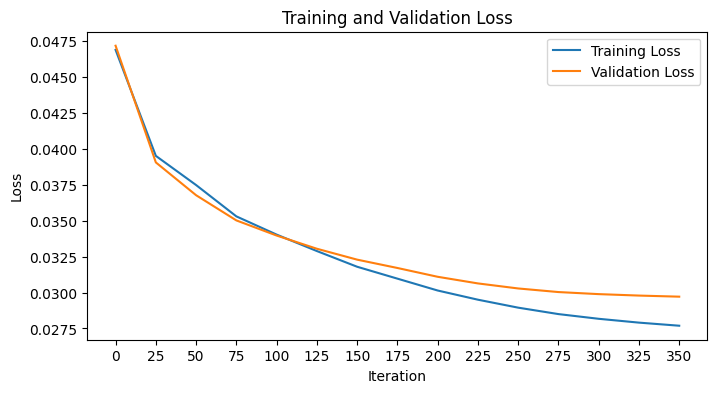

In [ ]:
def draw_loss(t_loss, val_loss):
    global val_tick
    # Plot train and validation loss
    plt.figure(figsize=(8, 4))
    xaxis = np.arange(0, len(t_loss) * val_tick, val_tick)
    plt.plot(xaxis, t_loss, label='Training Loss')
    plt.plot(xaxis, val_loss, label='Validation Loss')

    # Add in a title and axes labels
    plt.title('Training and Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    # Set the tick locations
    plt.xticks(xaxis)

    # Display the plot
    plt.legend(loc='best')
    plt.show()

draw_loss(train_losses, val_losses)

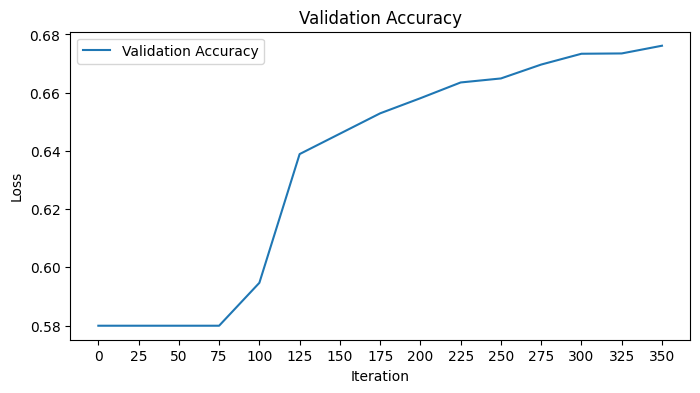

In [ ]:
def draw_accuracy(acc):
    # Plot train and validation loss
    plt.figure(figsize=(8, 4))
    xaxis = np.arange(0, len(acc) * val_tick, val_tick)
    plt.plot(xaxis, acc, label='Validation Accuracy')

    # Add in a title and axes labels
    plt.title('Validation Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    # Set the tick locations
    plt.xticks(xaxis)

    # Display the plot
    plt.legend(loc='best')
    plt.show()

draw_accuracy(val_acc)

# Evaluation

In [ ]:
def predict(model, df):
    model = model.to(device)
    X = torch.tensor(df.values).float().to(device)
    model.eval()
    with torch.no_grad():
        y_pred = model(X).reshape(-1).cpu().detach().numpy()
        # pred = threshold(y_pred.detach().numpy(), 5)
    return y_pred

pred = predict(model, val_dataset.drop("rating", axis=1).loc[1:3])

In [ ]:
def evaluate_ratings_recomendations(pred, true_y):
    print("MAE:", mean_absolute_error(true_y, pred))
    print("MSE:", mean_squared_error(true_y, pred, squared=True))
    print("RMSE:", mean_squared_error(true_y, pred, squared=False))

In [ ]:
print("Evaluation of normalized ratings:")
evaluate_ratings_recomendations(pred, (val_dataset.loc[1:3, "rating"].values)/4)

Evaluation of normalized ratings:
MAE: 0.17225577433904013
MSE: 0.04172060527181406
RMSE: 0.20425622456075618


In [ ]:
print("Evaluation of initial ratings:")
evaluate_ratings_recomendations(pred * 4 + 1, val_dataset.loc[1:3, "rating"].values + 1)

Evaluation of initial ratings:
MAE: 0.6890230973561605
MSE: 0.6675296843490249
RMSE: 0.8170248982430247


In [ ]:
def recommend_movies(user_id, k=5):
    global ua_base, ua_test, train_dataset
    # Predict movies unseen by user before
    # Both in train and test modes
    watched_movies = ua_base[ua_base["user_id"] == user_id]["item_id"].to_numpy()
    watched_movies_1 = ua_test[ua_test["user_id"] == user_id]["item_id"].to_numpy()
    watched_movies = np.unique(np.concatenate((watched_movies, watched_movies_1),0))

    # Prepare a data to put in a model
    df = processed_movies.drop(watched_movies, axis=0)
    df["item_id"] = df.index.copy()
    df["user_id"] = user_id
    df = df.merge(processed_users, left_on="user_id", right_index=True)
    df = df.drop("user_id", axis=1).reset_index(drop=True)

    # Predict movies ratings
    preds = predict(model, df[train_dataset.drop("rating", axis=1).columns])
    # Take ids of the top-rated movies
    res = df.loc[np.argsort(-preds)]["item_id"].values[:k]

    print(f"Recommended movies for user {user_id} are")
    for ind in res:
        print(movies.loc[ind, "movie_title"])

recommend_movies(21, k=10)

Recommended movies for user 21 are
Wrong Trousers, The (1993)
Santa with Muscles (1996)
Schindler's List (1993)
Citizen Kane (1941)
They Made Me a Criminal (1939)
Casablanca (1942)
Usual Suspects, The (1995)
Rear Window (1954)
Third Man, The (1949)
One Flew Over the Cuckoo's Nest (1975)
